#105 persons Recognition
# Small Exploratoary
  -> Number of images per person
  -> plot images
# Train,Valid,Test
# Test -> 5 persons from 105 are taken
# Train,valid -> 5fold
# TPU Training
 -> Build TFRecords
 -> Data Pipelines using tf.data
# Models+ArcFace
# Full Unfrezze
 -> Add Dense
 -> No Dense
# Partial Unfreeze
 -> Add Dense
 -> No Dense
# Naive search
# PQ search
# Use F1Score,recall

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sn
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
data={"path":[],"name":[]}
for curr_dir,folders,files in tqdm(os.walk("/kaggle/input/pins-face-recognition")):
    for file in files:
        if file.endswith(".jpg"):
            data['path'].append(os.path.join(curr_dir,file))
            name=os.path.basename(curr_dir).split("_")[-1]
            data['name'].append(name)
df=pd.DataFrame(data)

107it [00:08, 12.22it/s]


In [4]:
df.head()

,path,name
0,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
1,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
2,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
3,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
4,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17534 entries, 0 to 17533
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    17534 non-null  object
 1   name    17534 non-null  object
dtypes: object(2)
memory usage: 274.1+ KB


# Number of images per person

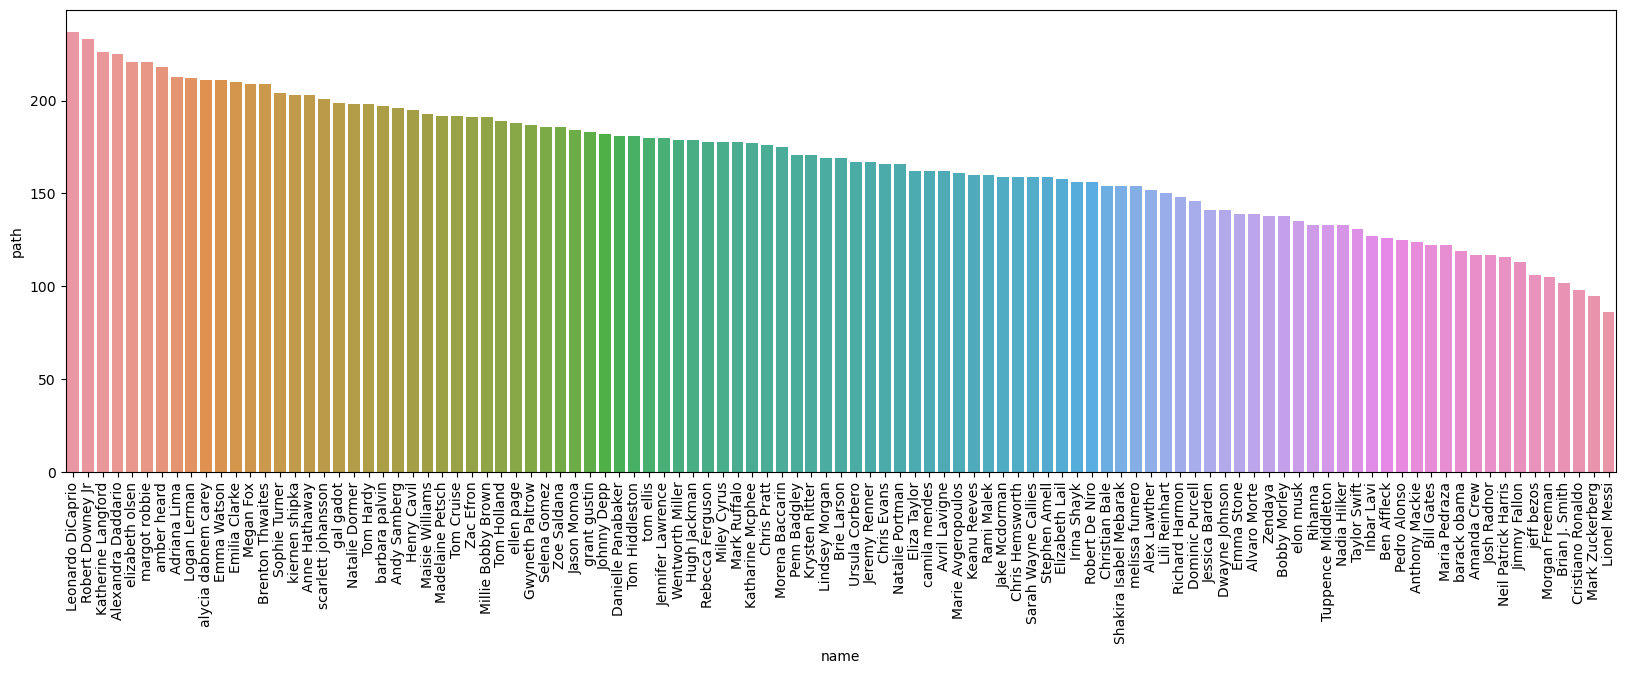

In [6]:
temp=df.groupby("name").count()
temp.sort_values(by='path',ascending=False,inplace=True)
plt.figure(figsize=(20,6))
sn.barplot(x=temp.index,y=temp.path)
plt.xticks(rotation=90)
plt.show()

In [7]:
temp.describe()

,path
count,105.000000
mean,166.990476
std,34.128855
min,86.000000
25%,141.000000
50%,169.000000
75%,192.000000
max,237.000000


We have minimum 86 images per person. It is for Messi and maximum of 237 images for Leonardo. On Average we have 192 images per person.

# Lets look at the images for 5 random people

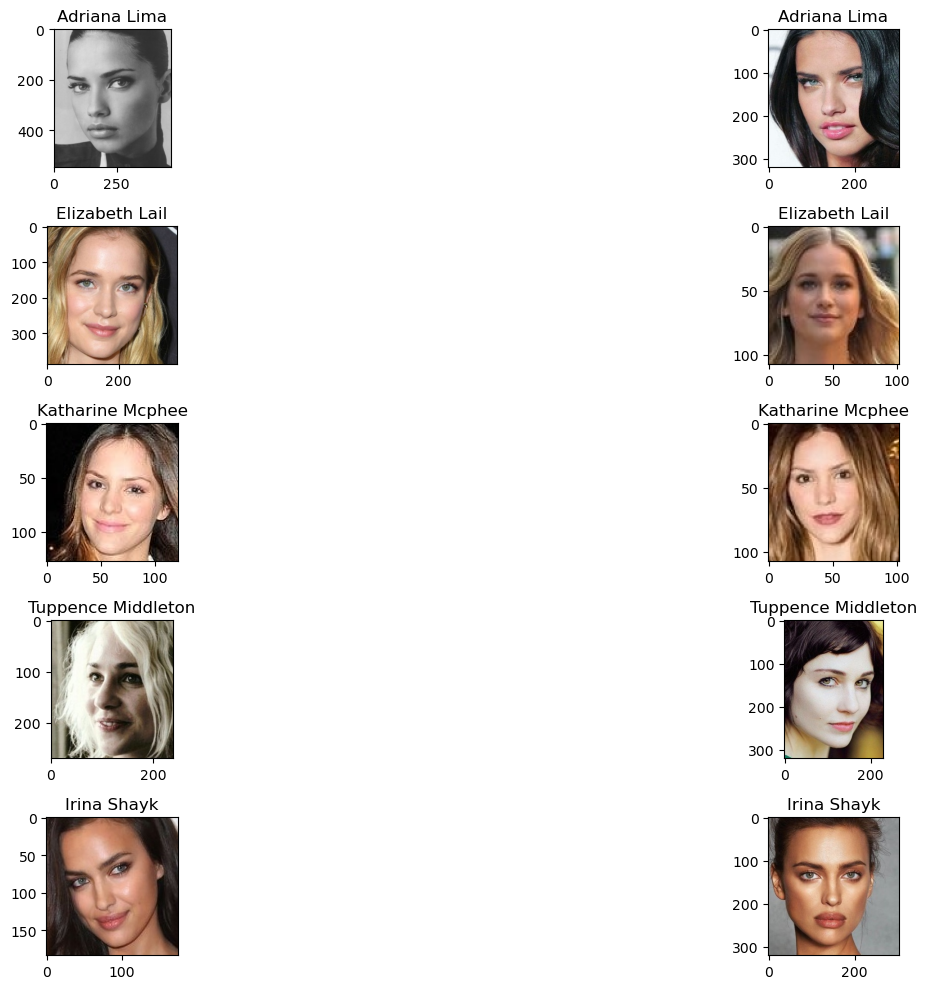

In [8]:
people=np.random.choice(temp.index,size=5)
plt.subplots(5,2,figsize=(20,10))
i=1
for person in people:
    images=df.loc[df['name']==person,'path'].values
    paths=np.random.choice(images,size=2)
    for path in paths:
        img=implt.imread(path)
        plt.subplot(5,2,i)
        plt.imshow(img)
        plt.title(person)
        i+=1
plt.tight_layout()
plt.show()

# If we run above code multiple times we get to see images of many people. The dataset is having images with different orientations, different expersions, different styles. In some images we have text.

How to tackle above problems:

-> Different Orientations: We can extract the face using MTCNN. This gives only the face. No background

-> The text is small in image. If we want to remove the text we have to train AutoEncoders.

Use MTCNN

In [3]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.9 MB/s eta 0:00:0000:0100:01


In [4]:
from functools import wraps
import sys
import io

Below function is to stop the logs of MTCNN. Taken from https://stackoverflow.com/questions/75231091/deepface-dont-print-logs-from-mtcnn-backend

In [5]:
def capture_output(func):
    """Wrapper to capture print output."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        new_stdout = io.StringIO()
        sys.stdout = new_stdout
        try:
            return func(*args, **kwargs)
        finally:
            sys.stdout = old_stdout

    return wrapper

In [6]:
from mtcnn import MTCNN
detector=MTCNN()

In [7]:
detector = capture_output(detector.detect_faces)

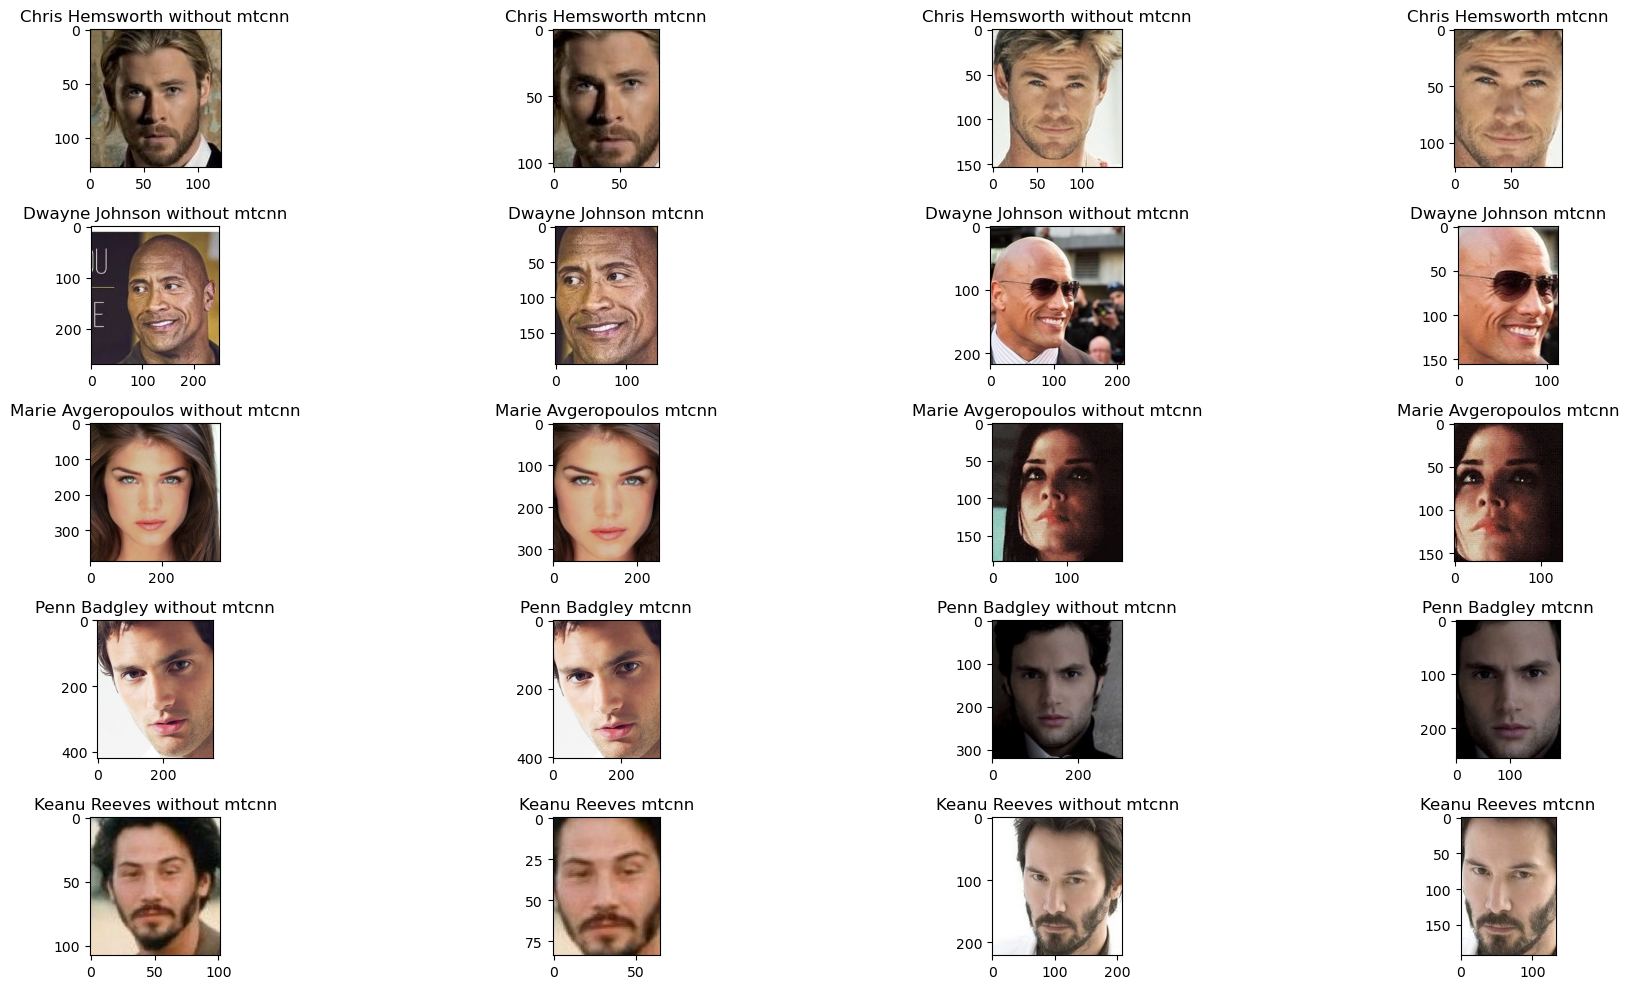

In [14]:
people=np.random.choice(temp.index,size=5)
plt.subplots(5,4,figsize=(20,10))
i=1
for person in people:
    images=df.loc[df['name']==person,'path'].values
    paths=np.random.choice(images,size=2)
    for path in paths:
        img=implt.imread(path)
        plt.subplot(5,4,i)
        plt.imshow(img)
        plt.title(f"{person} without mtcnn")
        i+=1
        box=detector(img)
        if len(box)!=0:
            x,y,width,height=box[0]['box']
            img=img[y:y+height,x:x+width]
        plt.subplot(5,4,i)
        plt.imshow(img)
        plt.title(f"{person} mtcnn")
        i+=1
plt.tight_layout()
plt.show()

# We can see that using MTCNN we almost got rid of the background and most of the image contains face

# Build TFRecords because when using TPUs. The processing of TFRecords and flow using tf.data is efficient.

In [15]:
people=np.random.choice(temp.index,size=5)
TEST=df.loc[df['name'].isin(people)].reset_index(drop=True)

In [16]:
df=df.loc[~df['name'].isin(people)].reset_index(drop=True)

In [17]:
df

,path,name
0,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
1,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
2,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
3,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
4,/kaggle/input/pins-face-recognition/105_classe...,Alex Lawther
...,...,...
16551,/kaggle/input/pins-face-recognition/105_classe...,Lili Reinhart
16552,/kaggle/input/pins-face-recognition/105_classe...,Lili Reinhart
16553,/kaggle/input/pins-face-recognition/105_classe...,Lili Reinhart
16554,/kaggle/input/pins-face-recognition/105_classe...,Lili Reinhart


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [19]:
encoder=LabelEncoder()
df['target']=encoder.fit_transform(df['name'])

In [20]:
kfold=StratifiedKFold(n_splits=5)
df['kfold']=0
for i,(train,valid) in enumerate(kfold.split(X=df['path'],y=df['target'])):
    df.loc[valid,'kfold']=i

In [21]:
for fold in range(5):
    print(f"for fold {fold}")
    train_labels=df.loc[df['kfold']!=fold,'target'].nunique()
    valid_labels=df.loc[df['kfold']==fold,'target'].nunique()
    print(f"train contains {train_labels} persons and valid contains {valid_labels}")

for fold 0
train contains 100 persons and valid contains 100
for fold 1
train contains 100 persons and valid contains 100
for fold 2
train contains 100 persons and valid contains 100
for fold 3
train contains 100 persons and valid contains 100
for fold 4
train contains 100 persons and valid contains 100


In [9]:
import cv2

In [10]:
def Path_to_array(path,target_size):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    box=detector(img)
    if len(box)!=0:
        x,y,width,height=box[0]['box']
        if width>80 and height>80:
            img=img[y:y+height,x:x+width]
    img=cv2.resize(img,target_size)
    return img

In [11]:
def Convert_to_Bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def Convert_to_InT(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
def Searlize_Example(image,label):
    features={"image":Convert_to_Bytes(image),"label":Convert_to_InT(label)}
    example=tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

In [13]:
#TEST.to_csv("Final_Test.csv",index=False)
#df.to_csv("Train_face.csv",index=False)

In [14]:
df=pd.read_csv("/kaggle/input/face-recognition-data/Train_face.csv")

In [15]:
for fold in range(4,5):
    fold_data=df.loc[df['kfold']==fold,['path','target']]
    fold_data.reset_index(drop=True,inplace=True)
    with tf.io.TFRecordWriter(f"pin_faces_fold_{fold}.tfrec") as writer:
        for i in fold_data.index:
            path=fold_data.loc[i,'path']
            label=fold_data.loc[i,'target']
            img=Path_to_array(path,(256,256))
            searlized_example=Searlize_Example(img.tostring(),label)
            writer.write(searlized_example)
    print(f"{fold} is done")

4 is done
